In [49]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('data/trabalho4_dados_4.csv')
df = df.astype(bool)
df

,ABSORVENTE,ACETONA,ACHOCOLATADO,ACUCAR,ADOCANTE,AGUA_OXIGENADA,AGUA,ALGODAO,AMENDOIN,AMONIA,...,TOALHA_DE_BANHO,TOALHA_DE_ROSTO,TORNEIRA,TORRADA,TRIGO_DE_QUIBE,UTEN_COZINHA,VELA_DE_FILTRO,VELA,VERDURAS,VINAGRE
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4780,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4781,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4782,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [51]:
itemsets = apriori(df, min_support=0.01, use_colnames=True)
itemsets

,support,itemsets
0,0.019440,(ABSORVENTE)
1,0.037625,(ACHOCOLATADO)
2,0.054557,(ACUCAR)
3,0.010242,(AMENDOIN)
4,0.010870,(APRESUNTADO)
...,...,...
1100,0.010452,"(FEIJAO, MACARRAO, PROD_LIMPEZA, PROD_BANHO, L..."
1101,0.010661,"(MACARRAO, OLEO_VEGETAL, PROD_LIMPEZA, LIMP_RO..."
1102,0.010661,"(MACARRAO, PROD_LIMPEZA, PROD_BANHO, LIMP_ROUP..."
1103,0.010242,"(MACARRAO, FEIJAO, PROD_LIMPEZA, LIMP_ROUPAS, ..."


Mediana de suporte para itemsets: 0.011496655518394648
Mediana de suporte para itemsets: 0.014005016722408026
Mediana de suporte para itemsets: 0.020066889632107024
Mediana de suporte para itemsets: 0.027550167224080258


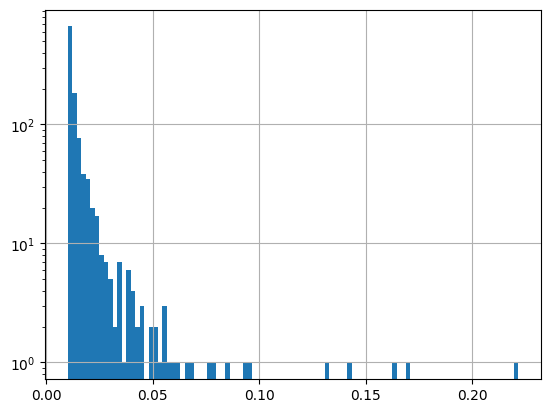

In [52]:
print(f"Mediana de suporte para itemsets: {itemsets['support'].median()}")
print(f"75% maiores suportes: {itemsets['support'].quantile(0.75)}")
print(f"90% maiores suportes: {itemsets['support'].quantile(0.90)}")
print(f"95% maiores suportes: {itemsets['support'].quantile(0.95)}")
itemsets['support'].hist(bins=100)
plt.yscale('log')

In [60]:
itemsets = apriori(df, min_support=0.02, use_colnames=True)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.01)
regras.sort_values(by="lift", ascending=False)
regras  

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ACUCAR),(ARROZ),0.054557,0.039925,0.020485,0.375479,9.404666,1.0,0.018307,1.537298,0.945239,0.276836,0.349508,0.444284
1,(ARROZ),(ACUCAR),0.039925,0.054557,0.020485,0.513089,9.404666,1.0,0.018307,1.941717,0.930833,0.276836,0.484992,0.444284
2,(ACUCAR),(BISCOITO),0.054557,0.221781,0.022366,0.409962,1.848498,1.0,0.010267,1.318930,0.485508,0.088066,0.241809,0.255405
3,(BISCOITO),(ACUCAR),0.221781,0.054557,0.022366,0.100848,1.848498,1.0,0.010267,1.051483,0.589834,0.088066,0.048963,0.255405
4,(ACUCAR),(CAFE),0.054557,0.059365,0.024247,0.444444,7.486698,1.0,0.021009,1.693144,0.916427,0.270396,0.409383,0.426448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,"(LEGUMES, LIMP_ROUPAS)",(PROD_LIMPEZA),0.025293,0.142977,0.020276,0.801653,5.606882,1.0,0.016660,4.320826,0.842969,0.137006,0.768563,0.471733
130,"(PROD_LIMPEZA, LIMP_ROUPAS)",(LEGUMES),0.051212,0.163253,0.020276,0.395918,2.425190,1.0,0.011915,1.385156,0.619381,0.104413,0.278060,0.260059
131,(LEGUMES),"(PROD_LIMPEZA, LIMP_ROUPAS)",0.163253,0.051212,0.020276,0.124200,2.425190,1.0,0.011915,1.083338,0.702316,0.104413,0.076927,0.260059
132,(PROD_LIMPEZA),"(LEGUMES, LIMP_ROUPAS)",0.142977,0.025293,0.020276,0.141813,5.606882,1.0,0.016660,1.135775,0.958723,0.137006,0.119544,0.471733


Mediana de confiaça para regras: 0.26059392726059394
75% maiores confianças: 0.3973950847944812
90% maiores confianças: 0.4943396226415095
95% maiores confianças: 0.5502294425623651


<Axes: >

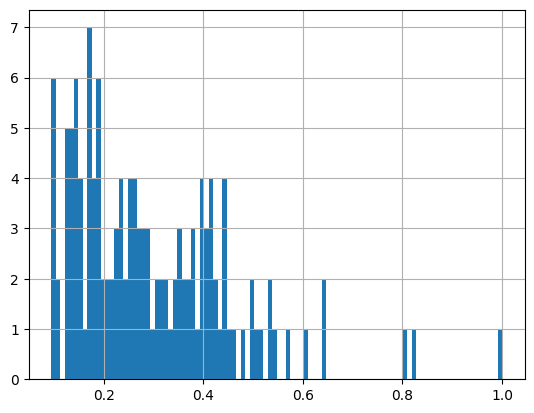

In [61]:
print(f"Mediana de confiaça para regras: {regras['confidence'].median()}")
print(f"75% maiores confianças: {regras['confidence'].quantile(0.75)}")
print(f"90% maiores confianças: {regras['confidence'].quantile(0.90)}")
print(f"95% maiores confianças: {regras['confidence'].quantile(0.95)}")
regras['confidence'].hist(bins=100)
# plt.yscale('log')

In [64]:
itemsets = apriori(df, min_support=0.02, use_colnames=True)
regras = association_rules(itemsets, len(df), metric="confidence", min_threshold=0.5)
regras.sort_values(by="lift", ascending=False)
regras  

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(ARROZ),(ACUCAR),0.039925,0.054557,0.020485,0.513089,9.404666,1.0,0.018307,1.941717,0.930833,0.276836,0.484992,0.444284
1,(ARROZ),(FEIJAO),0.039925,0.044314,0.021321,0.534031,12.050973,1.0,0.019552,2.050966,0.955153,0.338870,0.512425,0.507582
2,(ARROZ),(LEGUMES),0.039925,0.163253,0.021530,0.539267,3.303269,1.0,0.015012,1.816122,0.726266,0.118527,0.449376,0.335575
3,(CREME_DE_LEITE),(LEITE),0.035117,0.085075,0.035117,1.000000,11.754300,1.0,0.032129,inf,0.948224,0.412776,1.000000,0.706388
4,(EXTRATO_DE_TOMATE),(MACARRAO),0.033027,0.077341,0.020067,0.607595,7.856038,1.0,0.017513,2.351292,0.902517,0.222222,0.574702,0.433527
5,(FEIJAO),(LEGUMES),0.044314,0.163253,0.022157,0.500000,3.062740,1.0,0.014923,1.673495,0.704724,0.119504,0.402448,0.317862
6,(FEIJAO),(OLEO_VEGETAL),0.044314,0.061873,0.022157,0.500000,8.081081,1.0,0.019415,1.876254,0.916885,0.263682,0.467023,0.429054
7,(FEIJAO),(PROD_LIMPEZA),0.044314,0.142977,0.022575,0.509434,3.563059,1.0,0.016239,1.747009,0.752698,0.137056,0.427593,0.333664
8,(LIMP_ROUPAS),(PROD_LIMPEZA),0.079431,0.142977,0.051212,0.644737,4.509388,1.0,0.039856,2.412362,0.845391,0.299145,0.585469,0.501462
9,(MORTADELA),(PAES),0.034699,0.169314,0.022366,0.644578,3.806991,1.0,0.016491,2.337183,0.763829,0.123130,0.572135,0.388339
